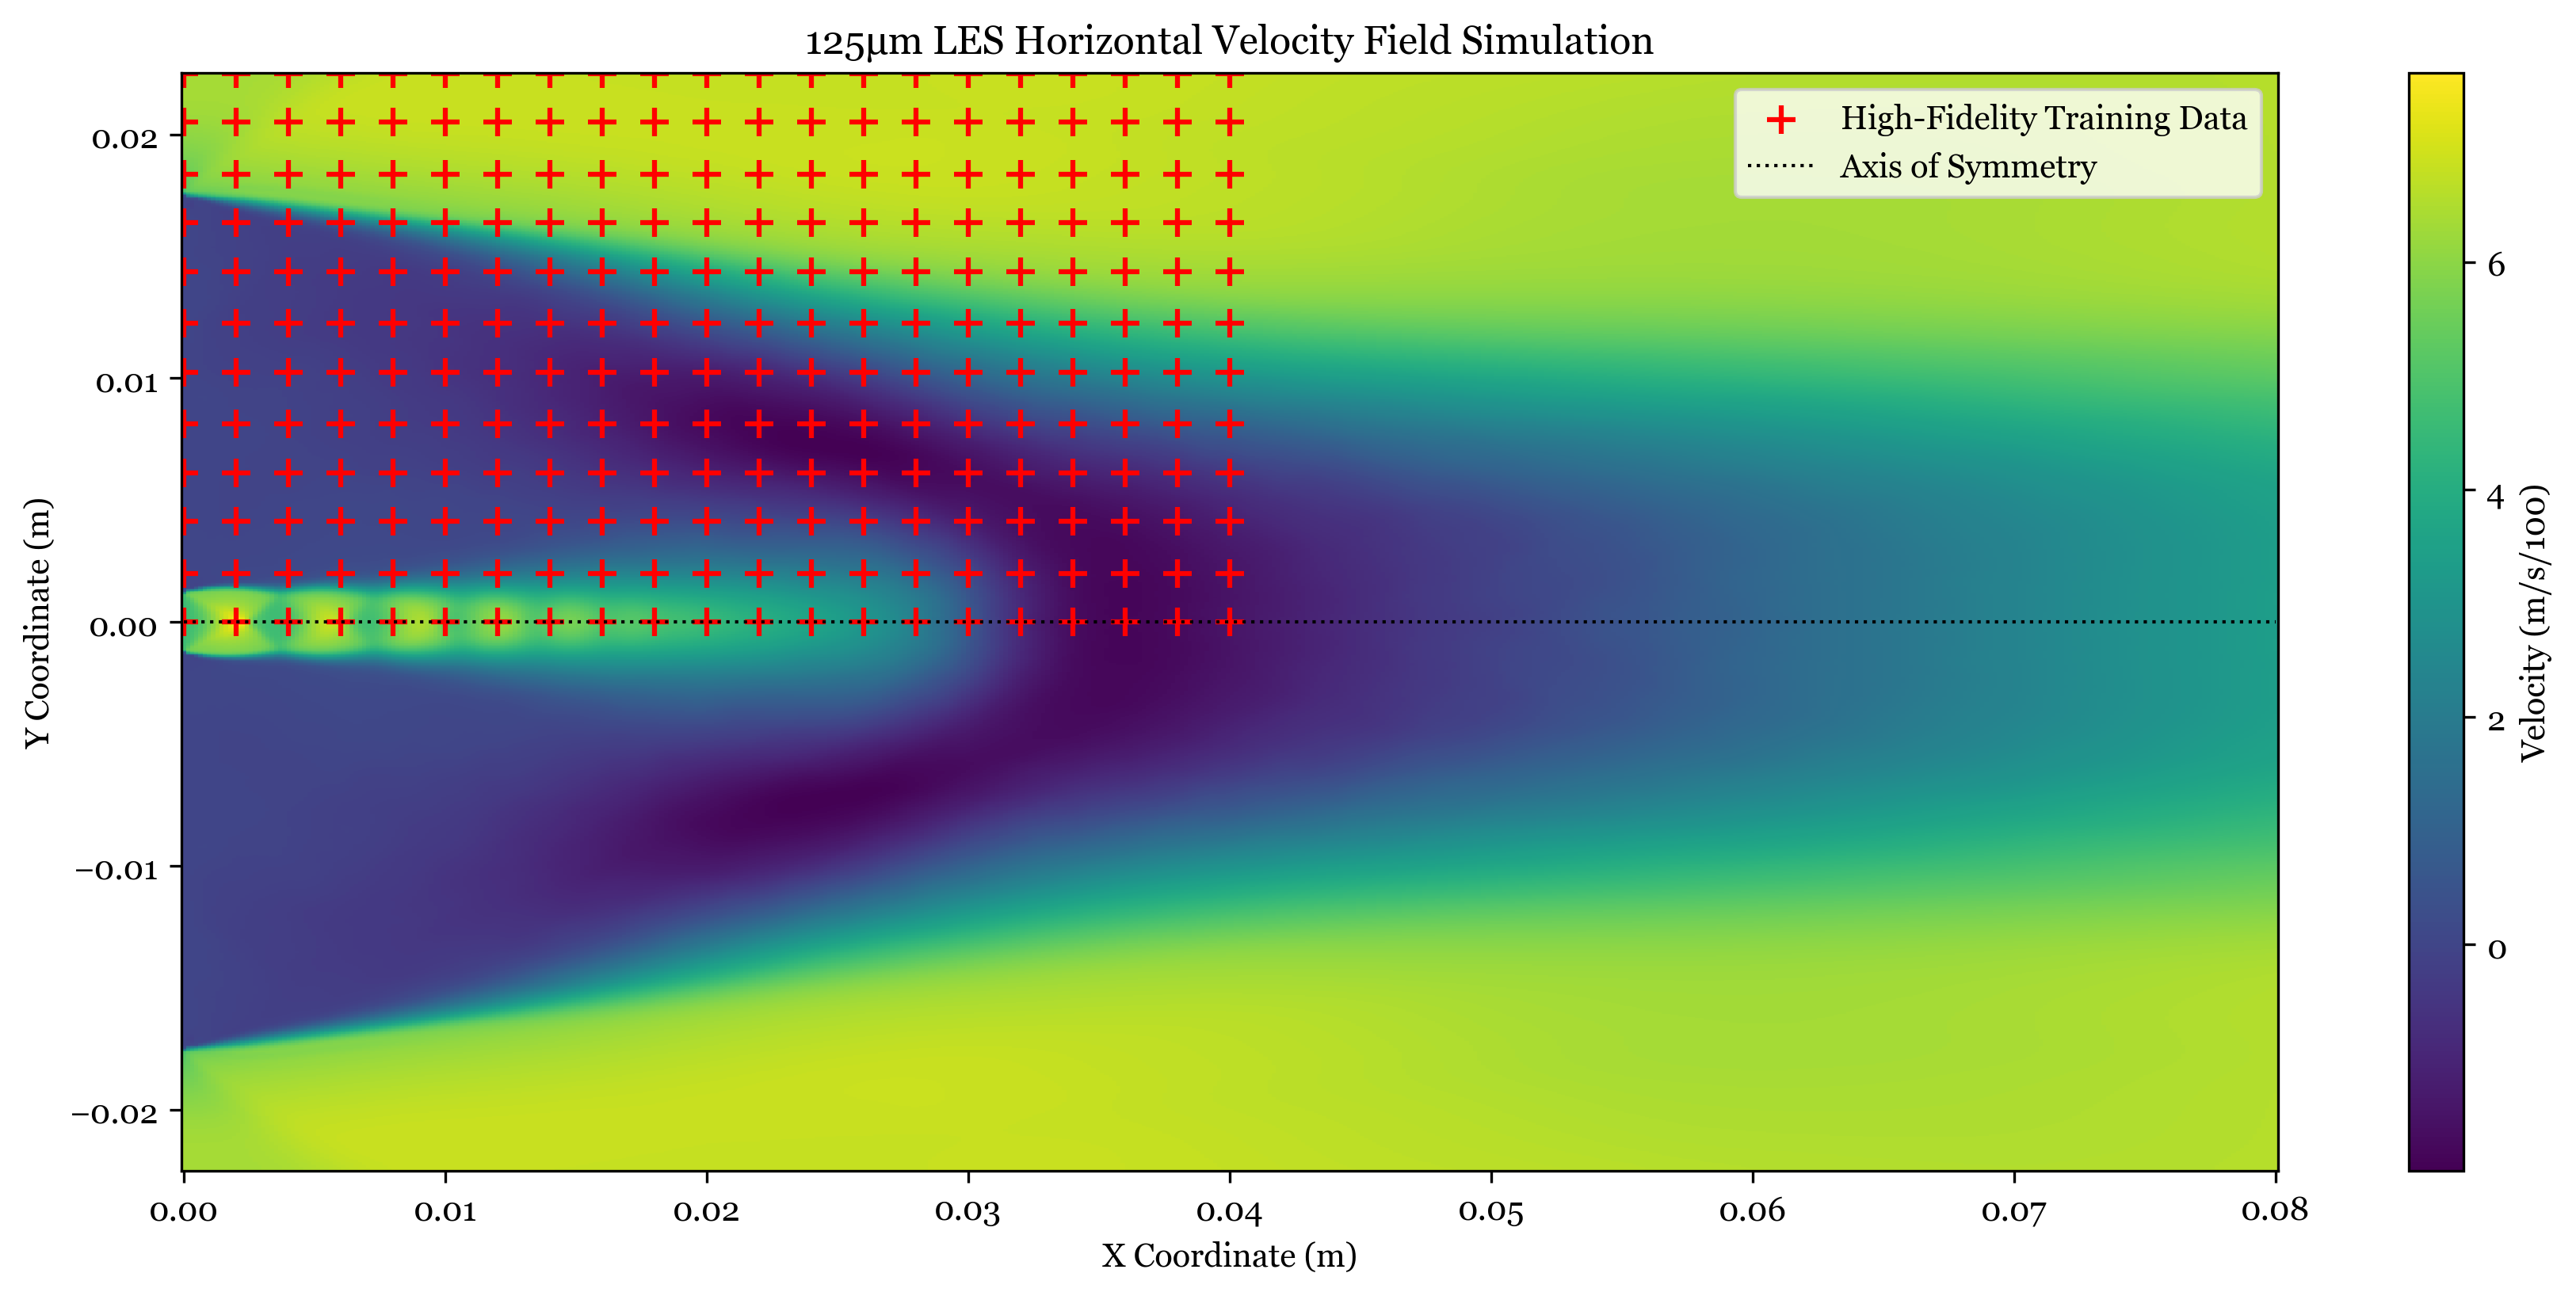

In [1]:
from util import * 

# Specifying target qoi and grid spacing 
target_qoi, grid_spacing = 'U', 0.002

# Loading data dictionary
scaler, data_dict, ratio, train_tuple, x_partitions = get_data_dict(target_qoi=target_qoi, grid_spacing=grid_spacing) 

# Extracting high-fidelity training data 
Xtrain, Ytrain = train_tuple

# Storing training and testing data
Xtest, Ytest = data_dict[4]['X'], data_dict[4][target_qoi]
data_dict[4]['X'], data_dict[4][target_qoi] = Xtrain, Ytrain

# Visualizing High-Fidelity training data 
plt.figure(figsize=(ratio * 4,6), dpi = 300)
X, Y, Z = to_grid(scaler.inverse_transform(Xtest), Ytest, N_partitions = 500)
plt.pcolormesh(X, Y, Z, cmap = 'viridis')

temp_X = np.copy(scaler.inverse_transform(Xtest))
temp_X[:,1] = -temp_X[:,1]
temp_Y = np.copy(Ytest)
X, Y, Z = to_grid(temp_X, temp_Y, N_partitions = 500)
plt.pcolormesh(X, Y, Z, cmap = 'viridis')

plt.colorbar(label = 'Velocity (m/s/100)')

plt.scatter(scaler.inverse_transform(Xtrain)[:,0], scaler.inverse_transform(Xtrain)[:,1], s = 75.0, c = 'red', label = "High-Fidelity Training Data", marker = '+')
plt.plot([0, 0.08], [0.0, 0.0], linestyle = 'dotted', linewidth =1.0, color = 'black', label = 'Axis of Symmetry')

plt.xlabel("X Coordinate (m)")
plt.ylabel("Y Coordinate (m)")
plt.title("125μm LES Horizontal Velocity Field Simulation")
plt.legend()

Text(0, 0.5, 'Y Coordinate')

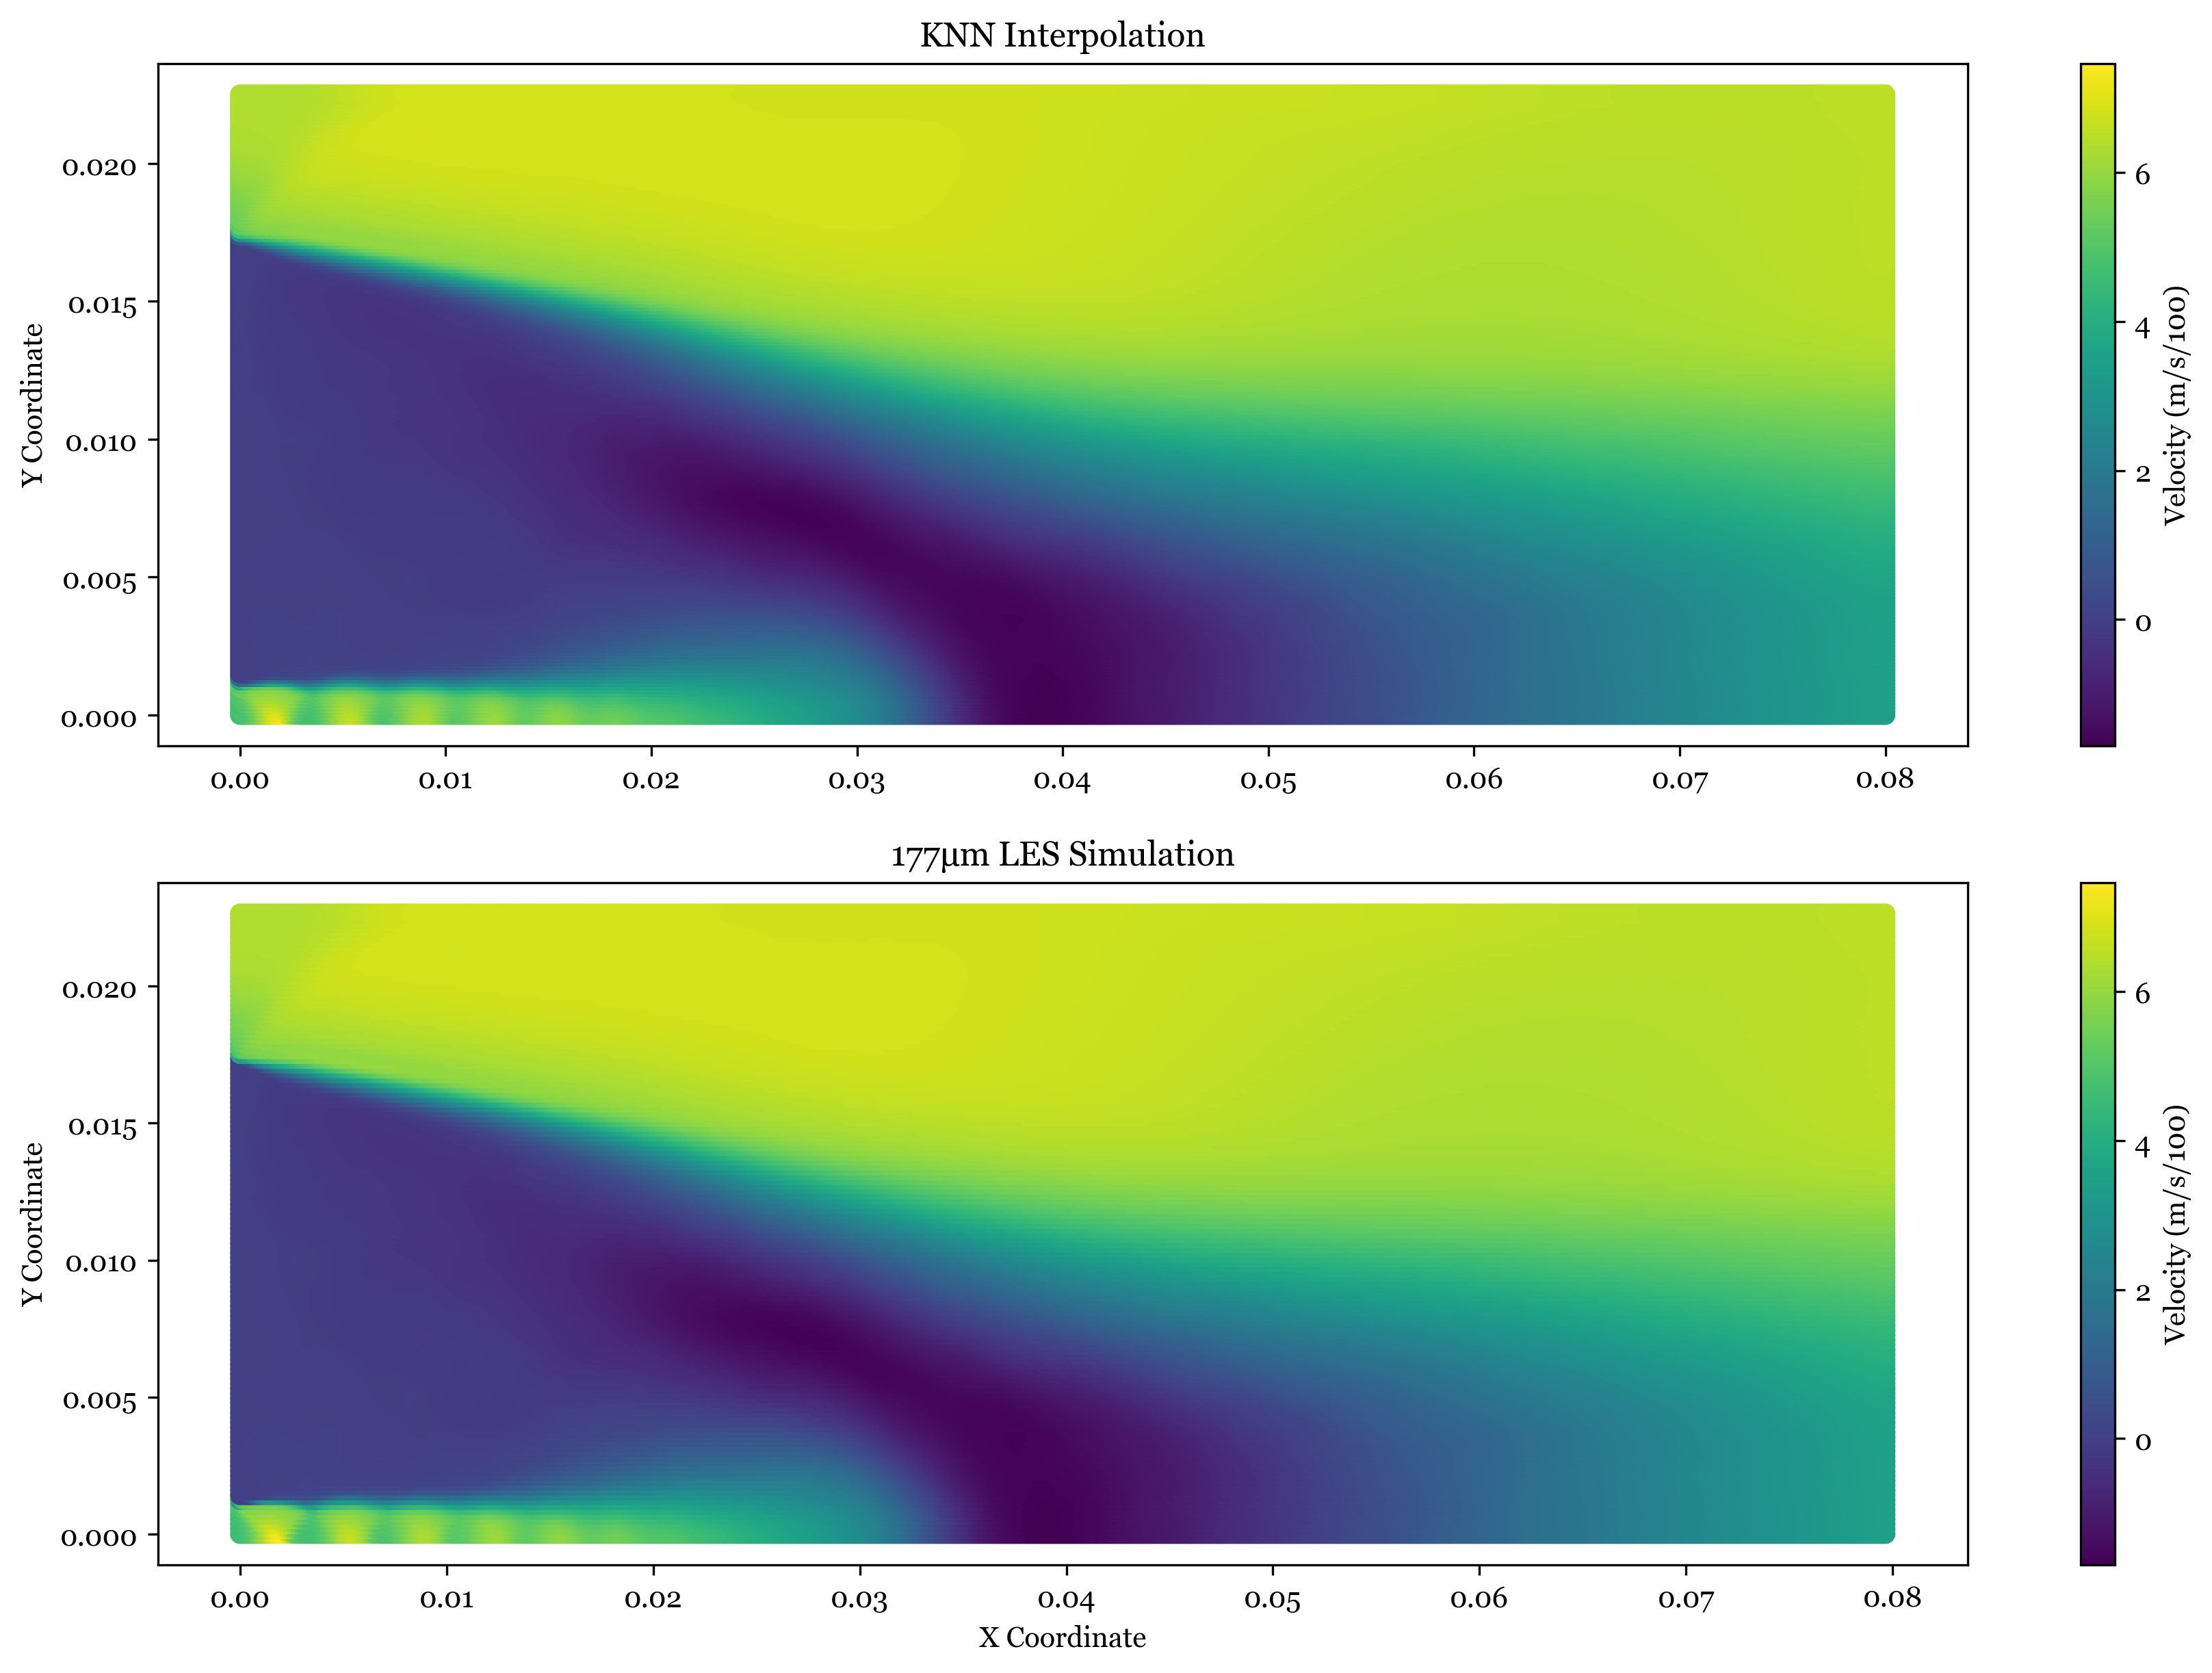

In [2]:
# Training low-fidelity surrogate models with KNN 
train_features, test_features = generate_features(data_dict, Xtrain, Xtest, n_neighbors = 10)

# Getting the 177micrometer testing predictions 
test_pred = test_features[:,-1]

# Obtaining the minimum and maximum velocity values 
vmin = min(test_pred.min(), data_dict[3][target_qoi].min())
vmax = max(test_pred.max(), data_dict[3][target_qoi].max())

plt.figure(figsize=(4*ratio, 4.75*2), dpi=300)

# First plot
plt.subplot(2, 1, 1)
plt.scatter(
    scaler.inverse_transform(Xtest)[:, 0],
    scaler.inverse_transform(Xtest)[:, 1],
    c=test_pred,
    cmap='viridis',
    vmin=vmin,
    vmax=vmax
)
plt.title("KNN Interpolation")
plt.colorbar(label='Velocity (m/s/100)')
plt.ylabel("Y Coordinate")

# Second plot
plt.subplot(2, 1, 2)
plt.scatter(
    scaler.inverse_transform(data_dict[3]['X'])[:, 0],
    scaler.inverse_transform(data_dict[3]['X'])[:, 1],
    c=data_dict[3]['Y'],
    cmap='viridis',
    vmin=vmin,
    vmax=vmax
)
plt.colorbar(label='Velocity (m/s/100)')
plt.title("177μm LES Simulation")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")

In [ ]:
# Creating a high-fidelity NARGP model with multi-fidelity features
nargp = GP(jnp.hstack((Xtrain, train_features[:,-1].reshape(-1,1))), Ytrain, NARGP_RBF, Linear, noise_var = 1e-2, epsilon = 1e-12, max_cond = 1e7, calibrate=True)
optimizer = Momentum(nargp, neg_mll, beta = 0.9)
optimizer.latin_hypercube_init('k_param', 1000, min=-100, max = 100, seed = 42)
optimizer.run(1e-2, 10000, ['k_param', 'm_param'])

Calibrated white noise variance: 1.0000e-02
Best Objective Value: -8.9581e+01


 66%|██████▌   | 6580/10000 [00:33<00:17, 193.45it/s, Loss: -1.4822e+02]

In [ ]:
# Creating a high-fidelity Hyperkriging model with multi-fidelity features
hk_model = GP(train_features, Ytrain, RBF, Linear, noise_var = 1e-2, epsilon = 1e-12, max_cond = 1e7, calibrate=True)
optimizer = Momentum(hk_model, neg_mll, beta = 0.9)
optimizer.latin_hypercube_init('k_param', 1000, min=-100, max = 100, seed = 42)
optimizer.run(1e-2, 10000, ['k_param', 'm_param'])

Calibrated white noise variance: 1.0000e-02
Best Objective Value: -1.5928e+02


100%|██████████| 10000/10000 [02:08<00:00, 77.62it/s, Loss: -1.7890e+02]


In [5]:
# Training a Kennedy O'Hagan autoregressive estimator on just the top two levels of fidelity
delta = DeltaGP(Xtrain, Ytrain, train_features[:,-1], RBF, Constant, max_cond = 1e6, calibrate = True, noise_var = 1e-3, epsilon = 1e-12)
koh_optimizer = Momentum(delta, delta_neg_mll, beta = 0.95)
koh_optimizer.latin_hypercube_init('k_param', 1000, min=-50, max = 50, seed = 42)
koh_optimizer.run(1e-4, 10000, ['rho', 'k_param', 'm_param'])

Calibrated white noise variance: 1.0000e-03
Best Objective Value: 1.0005e+02


100%|██████████| 10000/10000 [00:43<00:00, 230.38it/s, Loss: -9.1522e+01]


In [ ]:
# Training a high-fidelity Kriging model 
kr_model = GP(Xtrain, Ytrain, RBF, Linear, kernel_params = jnp.ones(3), noise_var = 1e-3, epsilon = 1e-12, max_cond = 1e6, calibrate=True)
kr_optimizer = Momentum(kr_model, neg_mll, beta = 0.9)
kr_optimizer.latin_hypercube_init('k_param', 1000, min=-100, max = 100, seed = 42)
kr_optimizer.run(1e-5, 10000, ['k_param', 'm_param'])

Calibrated white noise variance: 1.7716e-03


100%|██████████| 10000/10000 [00:43<00:00, 231.15it/s, Loss: 2.8276e+02]


In [13]:
kr_optimizer.run(1e-3, 10000, ['k_param', 'm_param'])

100%|██████████| 10000/10000 [00:43<00:00, 232.05it/s, Loss: 2.7387e+02]


In [31]:
from sklearn.metrics import mean_squared_error as MSE 
hk_mean, _ = hk_model.predict(test_features, full_cov = False) 

# Making predictions using the kennedy o'hagan estimator
delta_mean, _ = delta.predict(Xtest, full_cov = False)
koh_mean = delta.p['rho'] * test_features[:,-1] + delta_mean 

# Making predictions using the nargp estimator
nargp_mean, _ = nargp.predict(jnp.hstack((Xtest, test_features[:,-1].reshape(-1,1))), full_cov=False)

# Making predictions using the high-fidelity Kriging model
kr_mean, _ = kr_model.predict(Xtest, full_cov = False)

# Specifying only the training data within the grid 
grid_criterion = (Xtest[:,0] <= (x_partitions-1) * grid_spacing)

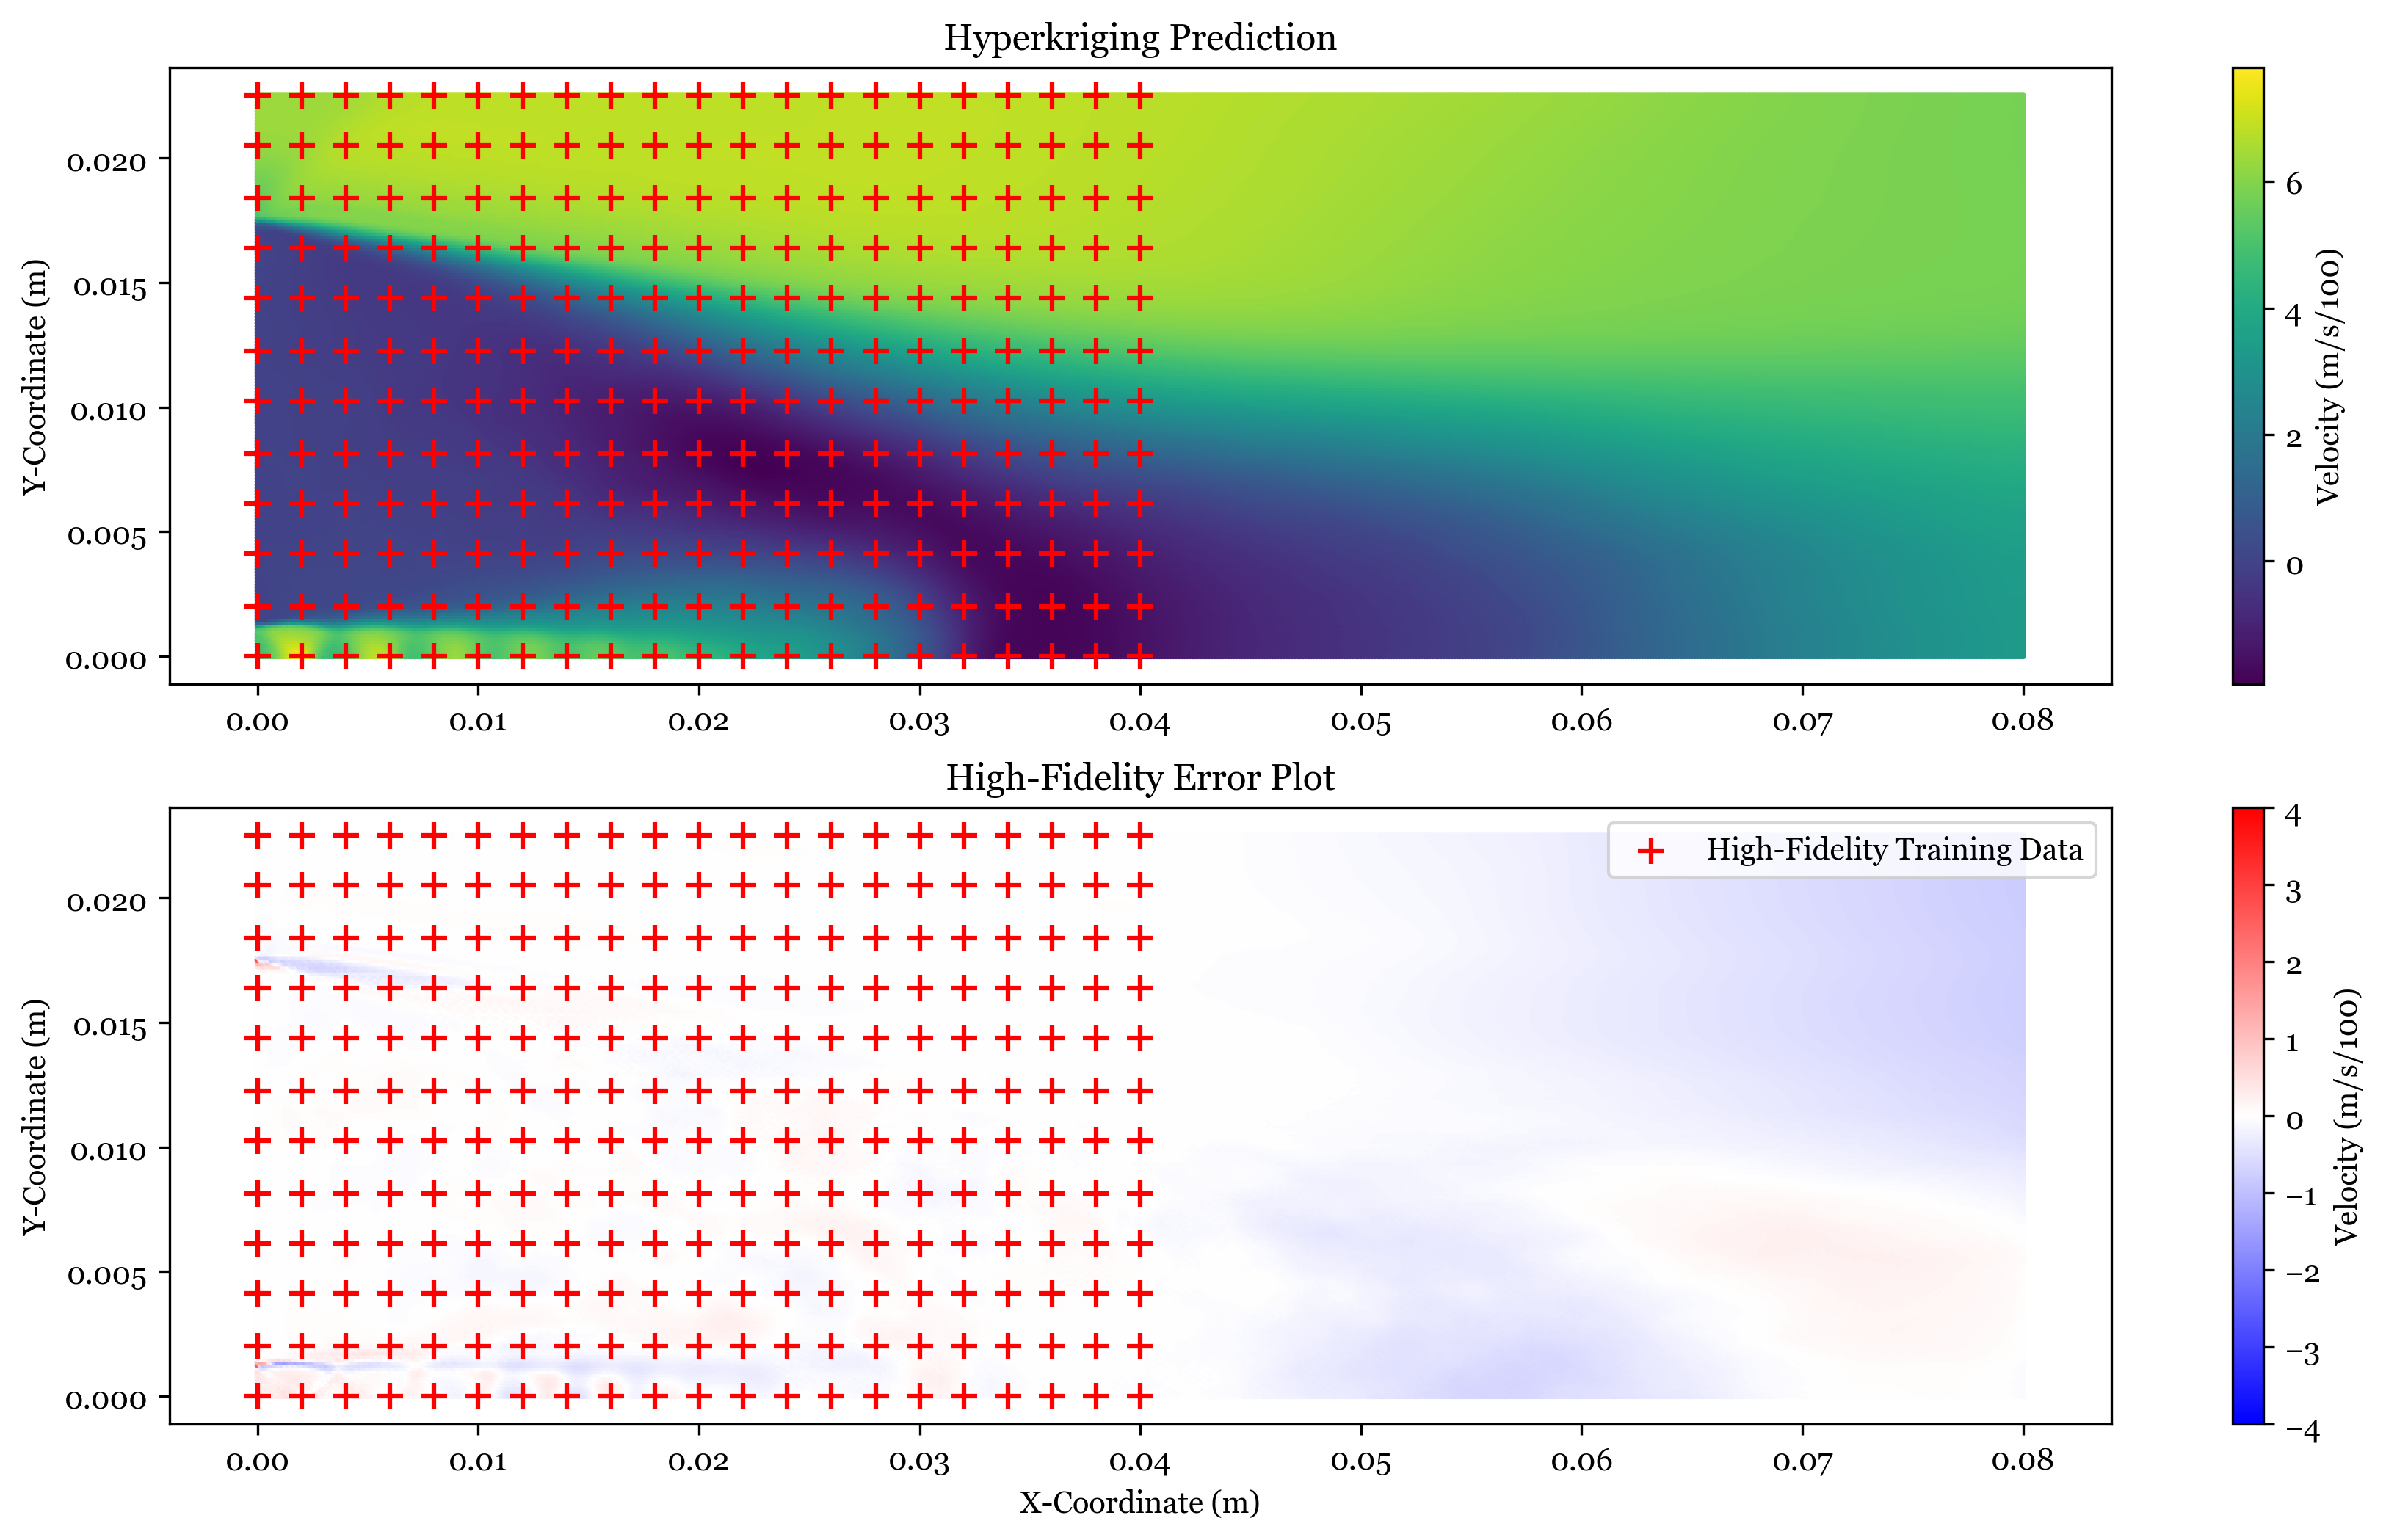

In [15]:
# Making predictions on test features
plt.figure(figsize=(4*ratio,4*2), dpi = 300)

plt.subplot(2,1,1)
plt.title("Hyperkriging Prediction")

plt.scatter(scaler.inverse_transform(Xtest)[:,0], scaler.inverse_transform(Xtest)[:,1], c = hk_mean, cmap = 'viridis', s = 1.0)
plt.colorbar(label = "Velocity (m/s/100)")
plt.scatter(scaler.inverse_transform(Xtrain)[:,0], scaler.inverse_transform(Xtrain)[:,1], c = 'red', s = 75, marker = '+', label = "High-Fidelity Training Data")
plt.ylabel("Y-Coordinate (m)")

plt.subplot(2,1,2)
from matplotlib.colors import TwoSlopeNorm
diff = hk_mean - Ytest
norm = TwoSlopeNorm(vmin=-4, vcenter=0, vmax=4)
im = plt.scatter(scaler.inverse_transform(Xtest)[:,0], scaler.inverse_transform(Xtest)[:,1], c = hk_mean - Ytest, cmap = 'bwr', norm = norm, s = 1.0)
cbar = plt.colorbar(label = "Velocity (m/s/100)")
plt.title("High-Fidelity Error Plot")
plt.scatter(scaler.inverse_transform(Xtrain)[:,0], scaler.inverse_transform(Xtrain)[:,1], c = 'red', s = 75, marker = '+', label = "High-Fidelity Training Data")
plt.ylabel("Y-Coordinate (m)")
plt.xlabel("X-Coordinate (m)")
plt.legend()

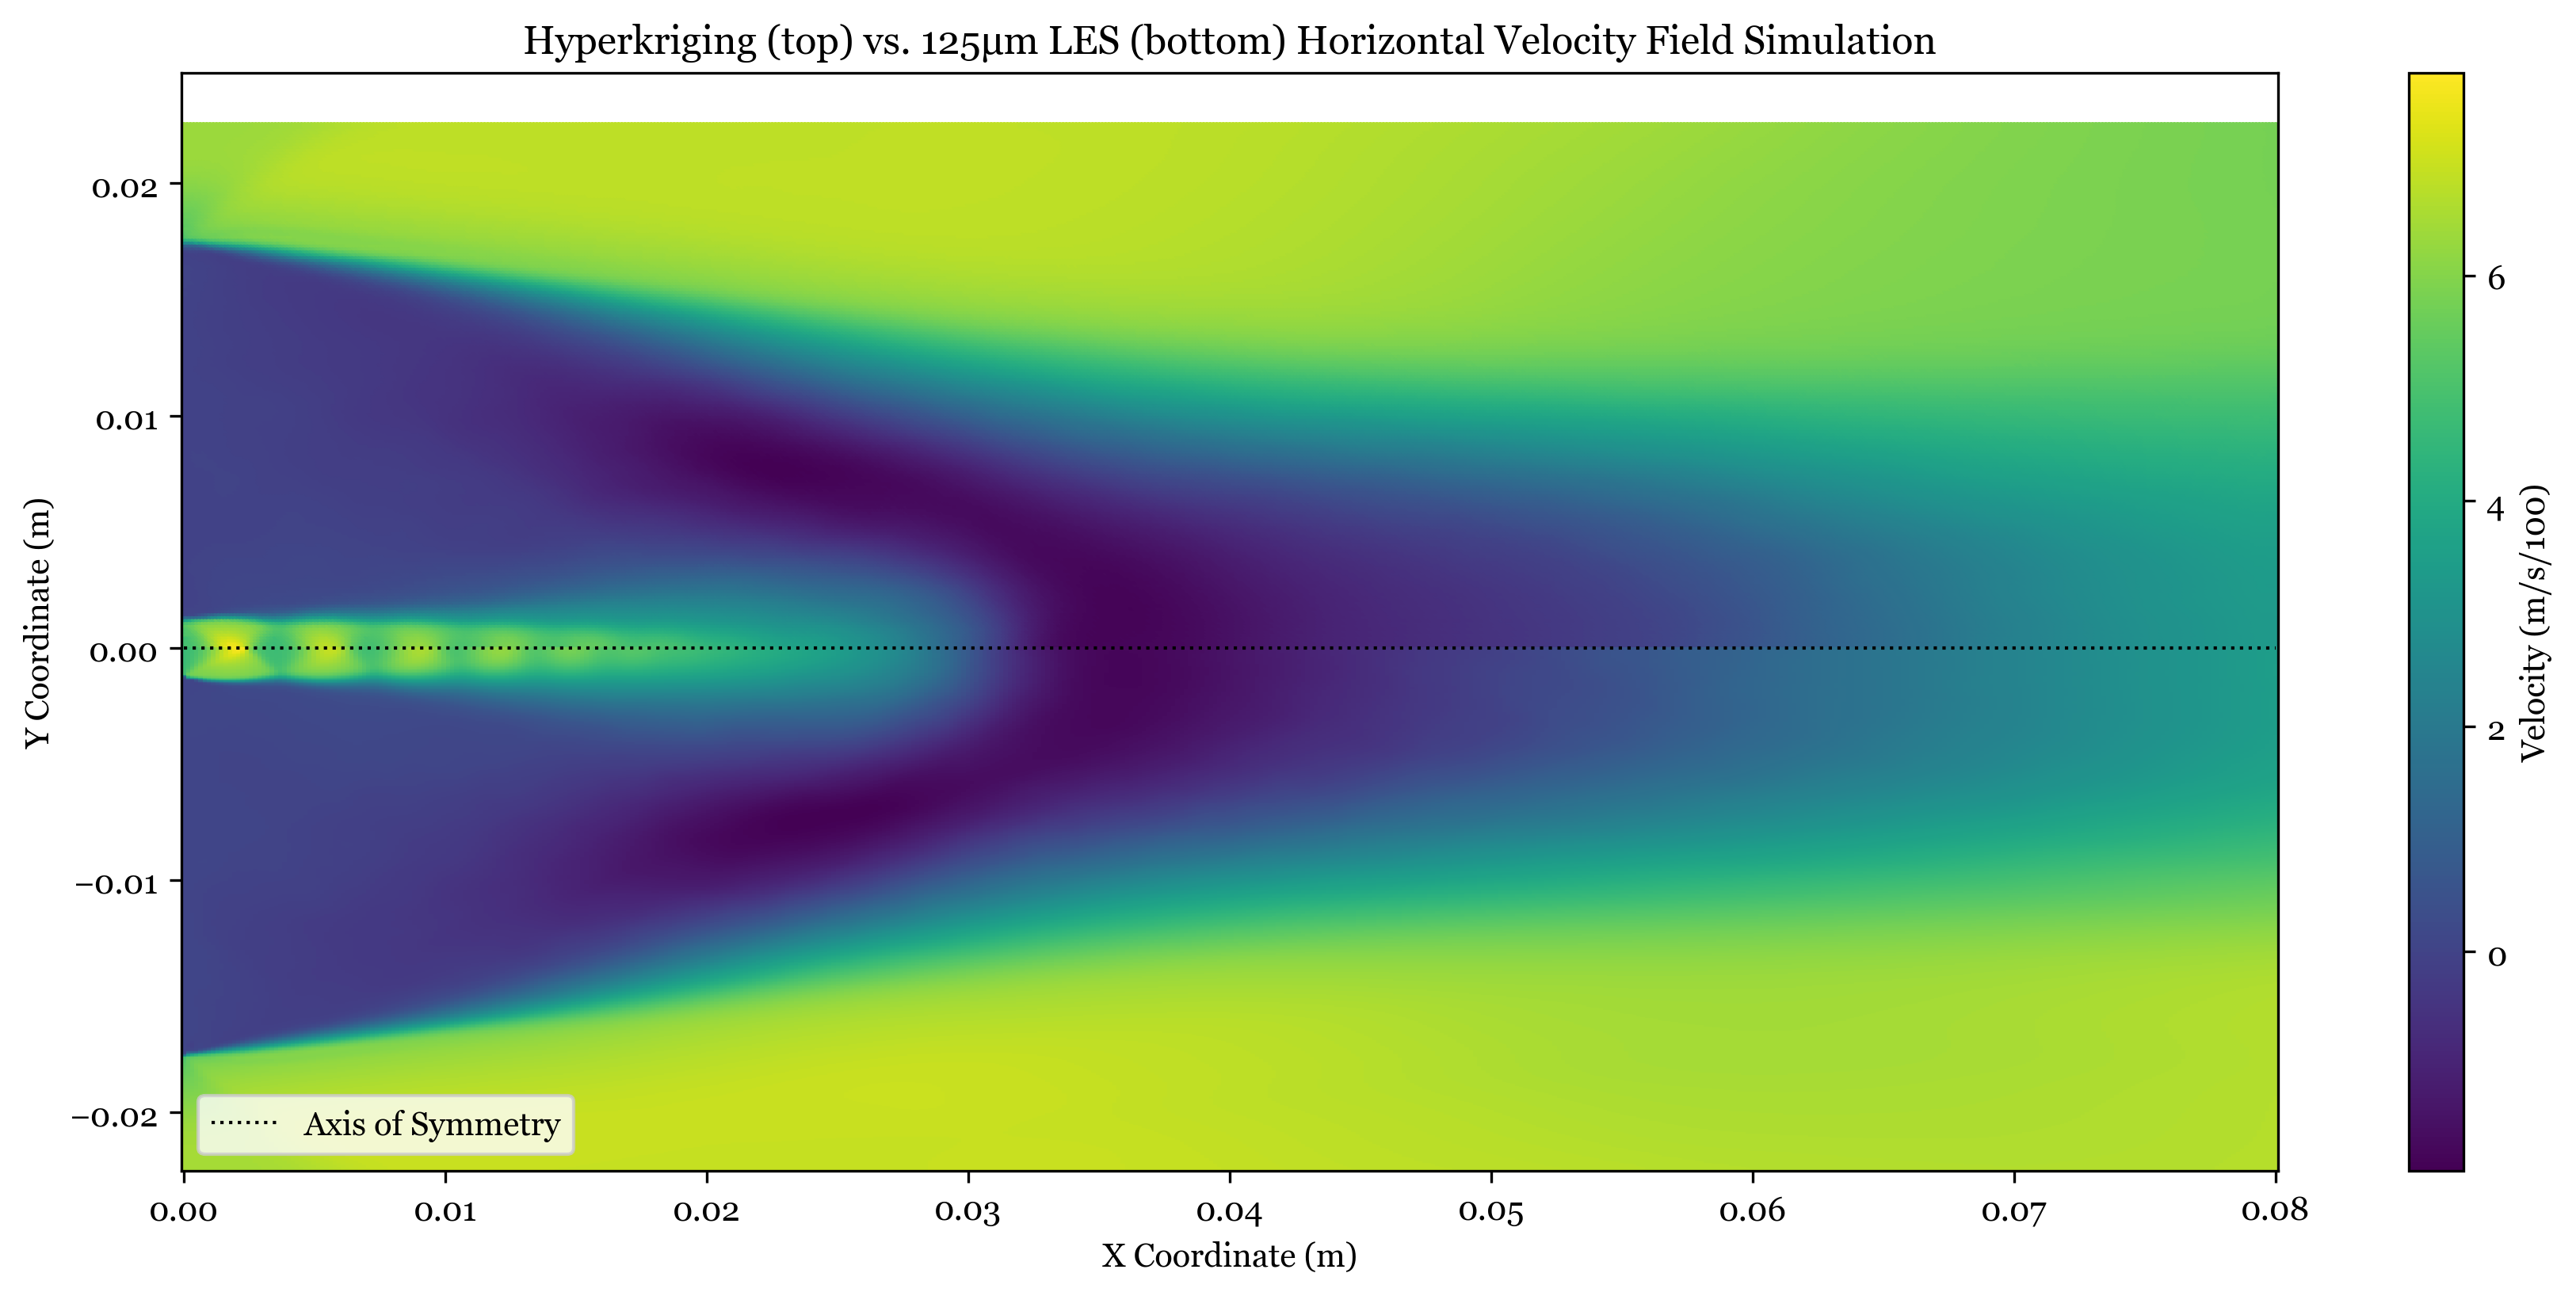

In [16]:
# Visualizing High-Fidelity training data 
plt.figure(figsize=(ratio * 4,6), dpi = 300)


plt.scatter(scaler.inverse_transform(Xtest)[:,0], scaler.inverse_transform(Xtest)[:,1], c = hk_mean, cmap = 'viridis', s = 1.0)
plt.colorbar(label = "Velocity (m/s/100)")


X, Y, Z = to_grid(temp_X, temp_Y, N_partitions = 500)
plt.pcolormesh(X, Y, Z, cmap = 'viridis')

plt.plot([0, 0.08], [0.0, 0.0], linestyle = 'dotted', linewidth =1.0, color = 'black', label = 'Axis of Symmetry')

plt.xlabel("X Coordinate (m)")
plt.ylabel("Y Coordinate (m)")
plt.title("Hyperkriging (top) vs. 125μm LES (bottom) Horizontal Velocity Field Simulation")
plt.legend()

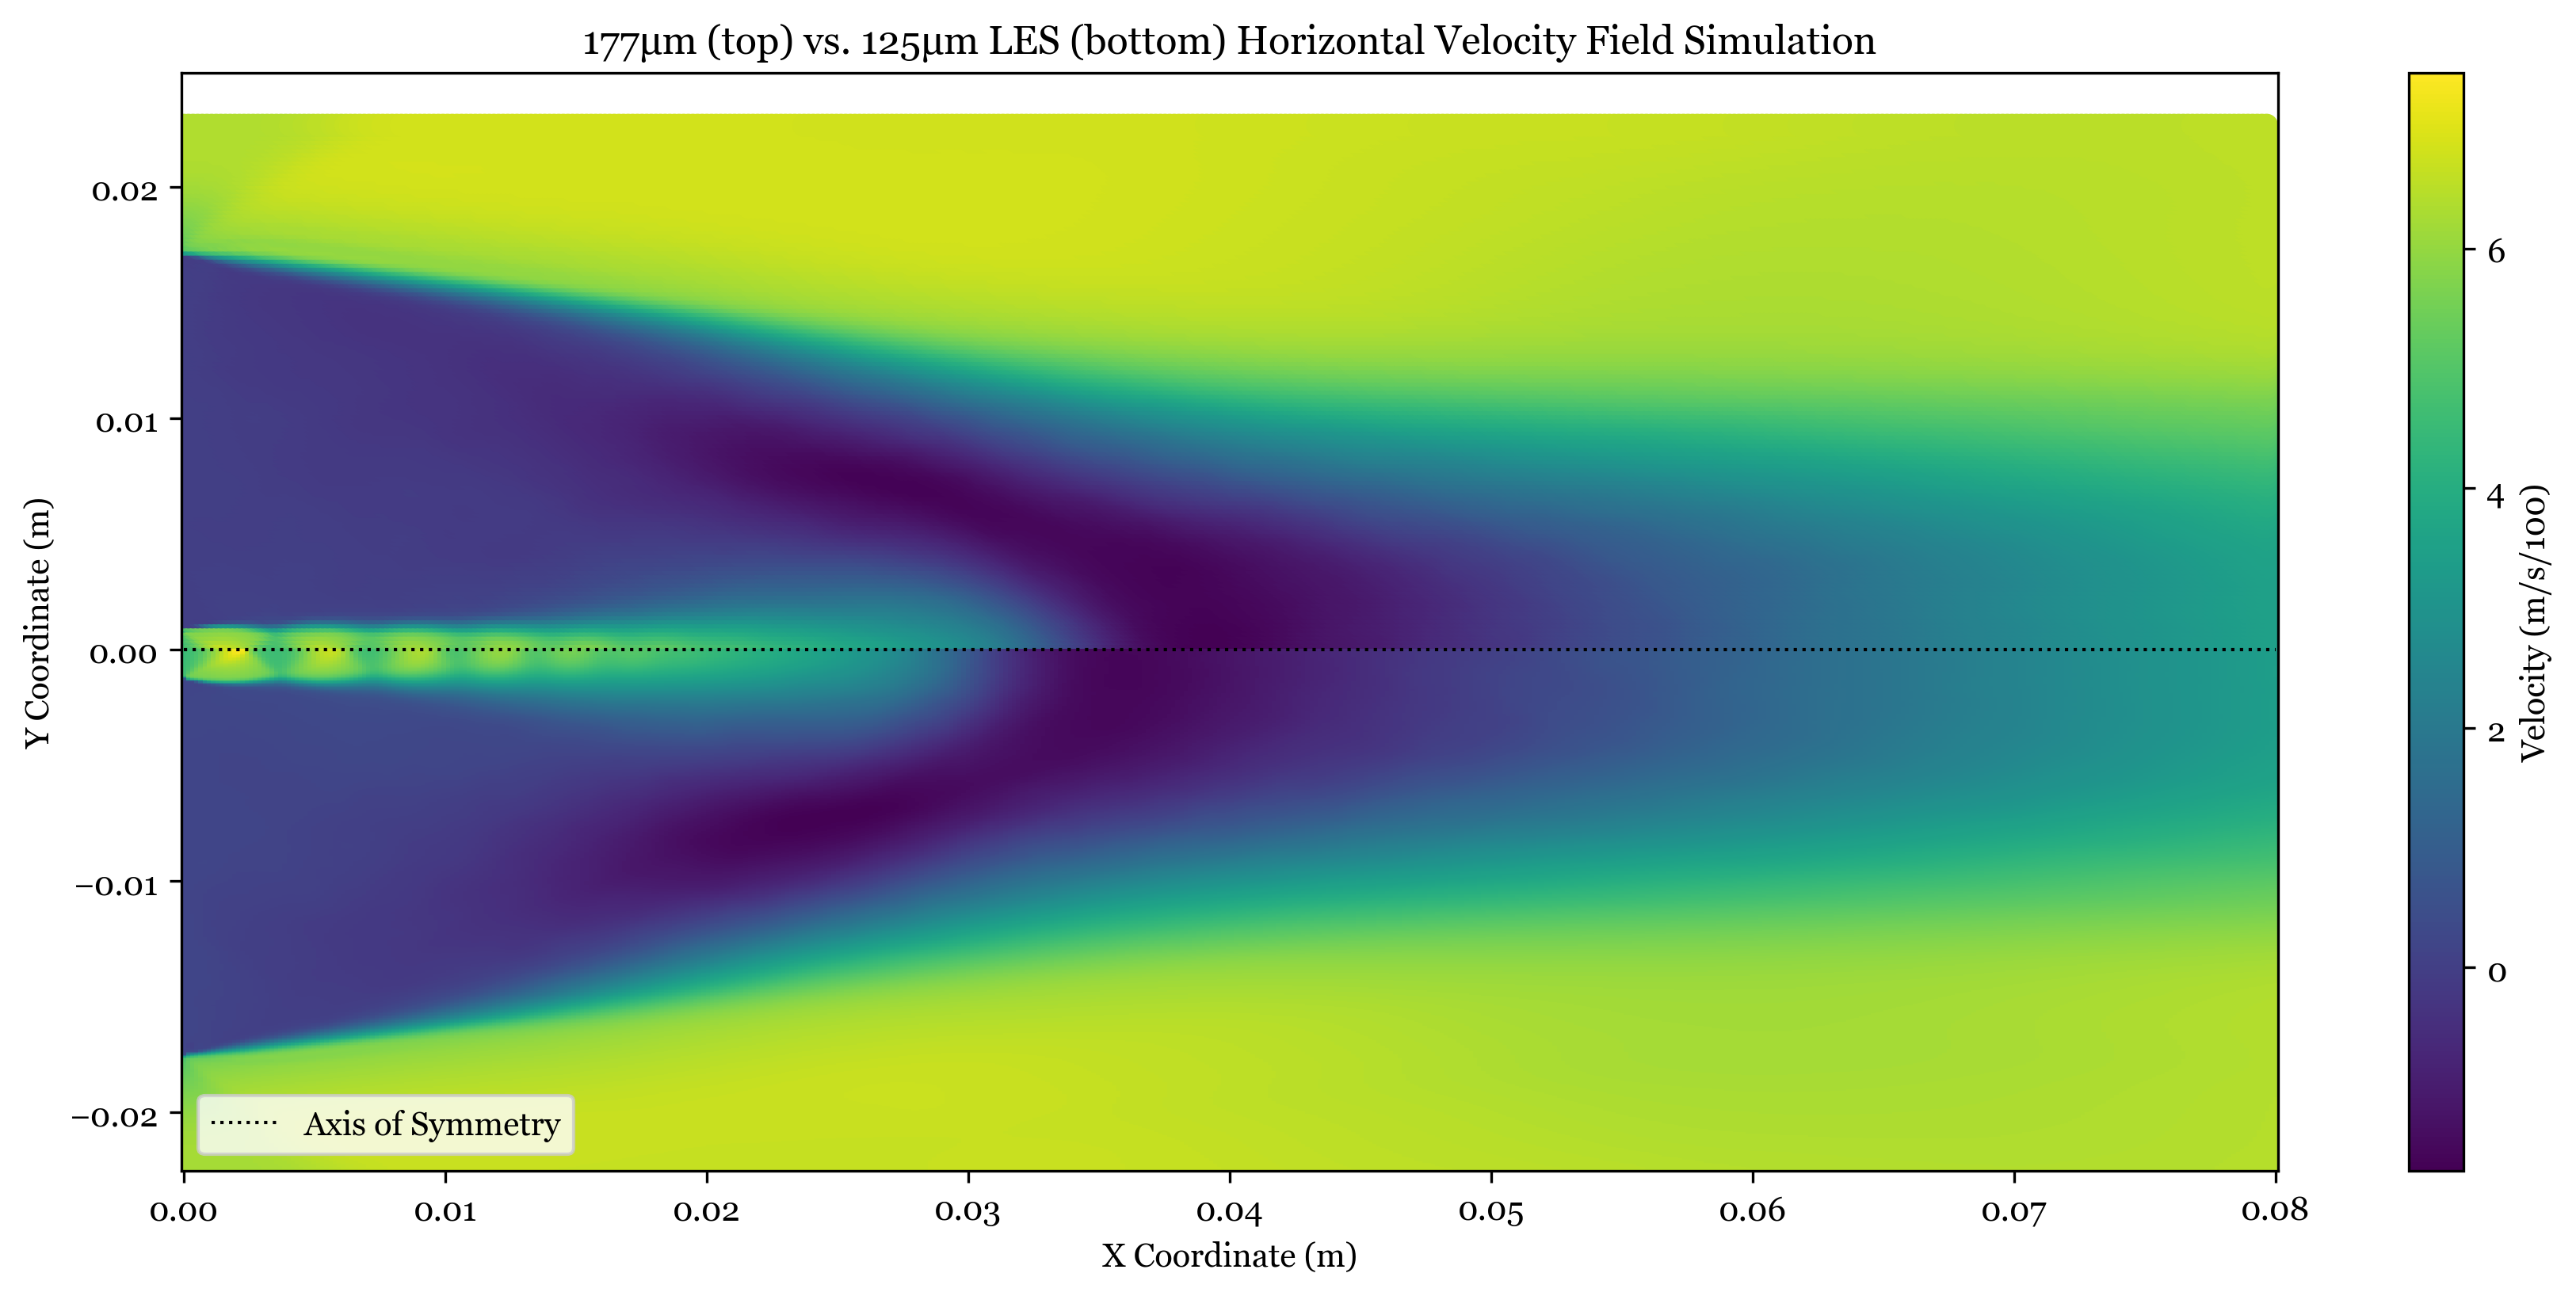

In [ ]:
# Visualizing High-Fidelity training data 
plt.figure(figsize=(ratio * 4,6), dpi = 300)


plt.scatter(
    scaler.inverse_transform(data_dict[3]['X'])[:, 0],
    scaler.inverse_transform(data_dict[3]['X'])[:, 1],
    c=data_dict[3]['Y'],
    cmap='viridis',
    vmin=vmin,
    vmax=vmax
)
plt.colorbar(label = "Velocity (m/s/100)")


X, Y, Z = to_grid(temp_X, temp_Y, N_partitions = 500)
plt.pcolormesh(X, Y, Z, cmap = 'viridis')

plt.plot([0, 0.08], [0.0, 0.0], linestyle = 'dotted', linewidth =1.0, color = 'black', label = 'Axis of Symmetry')

plt.xlabel("X Coordinate (m)")
plt.ylabel("Y Coordinate (m)")
plt.title("177μm (top) vs. 125μm LES (bottom) Horizontal Velocity Field Simulation")
plt.legend()

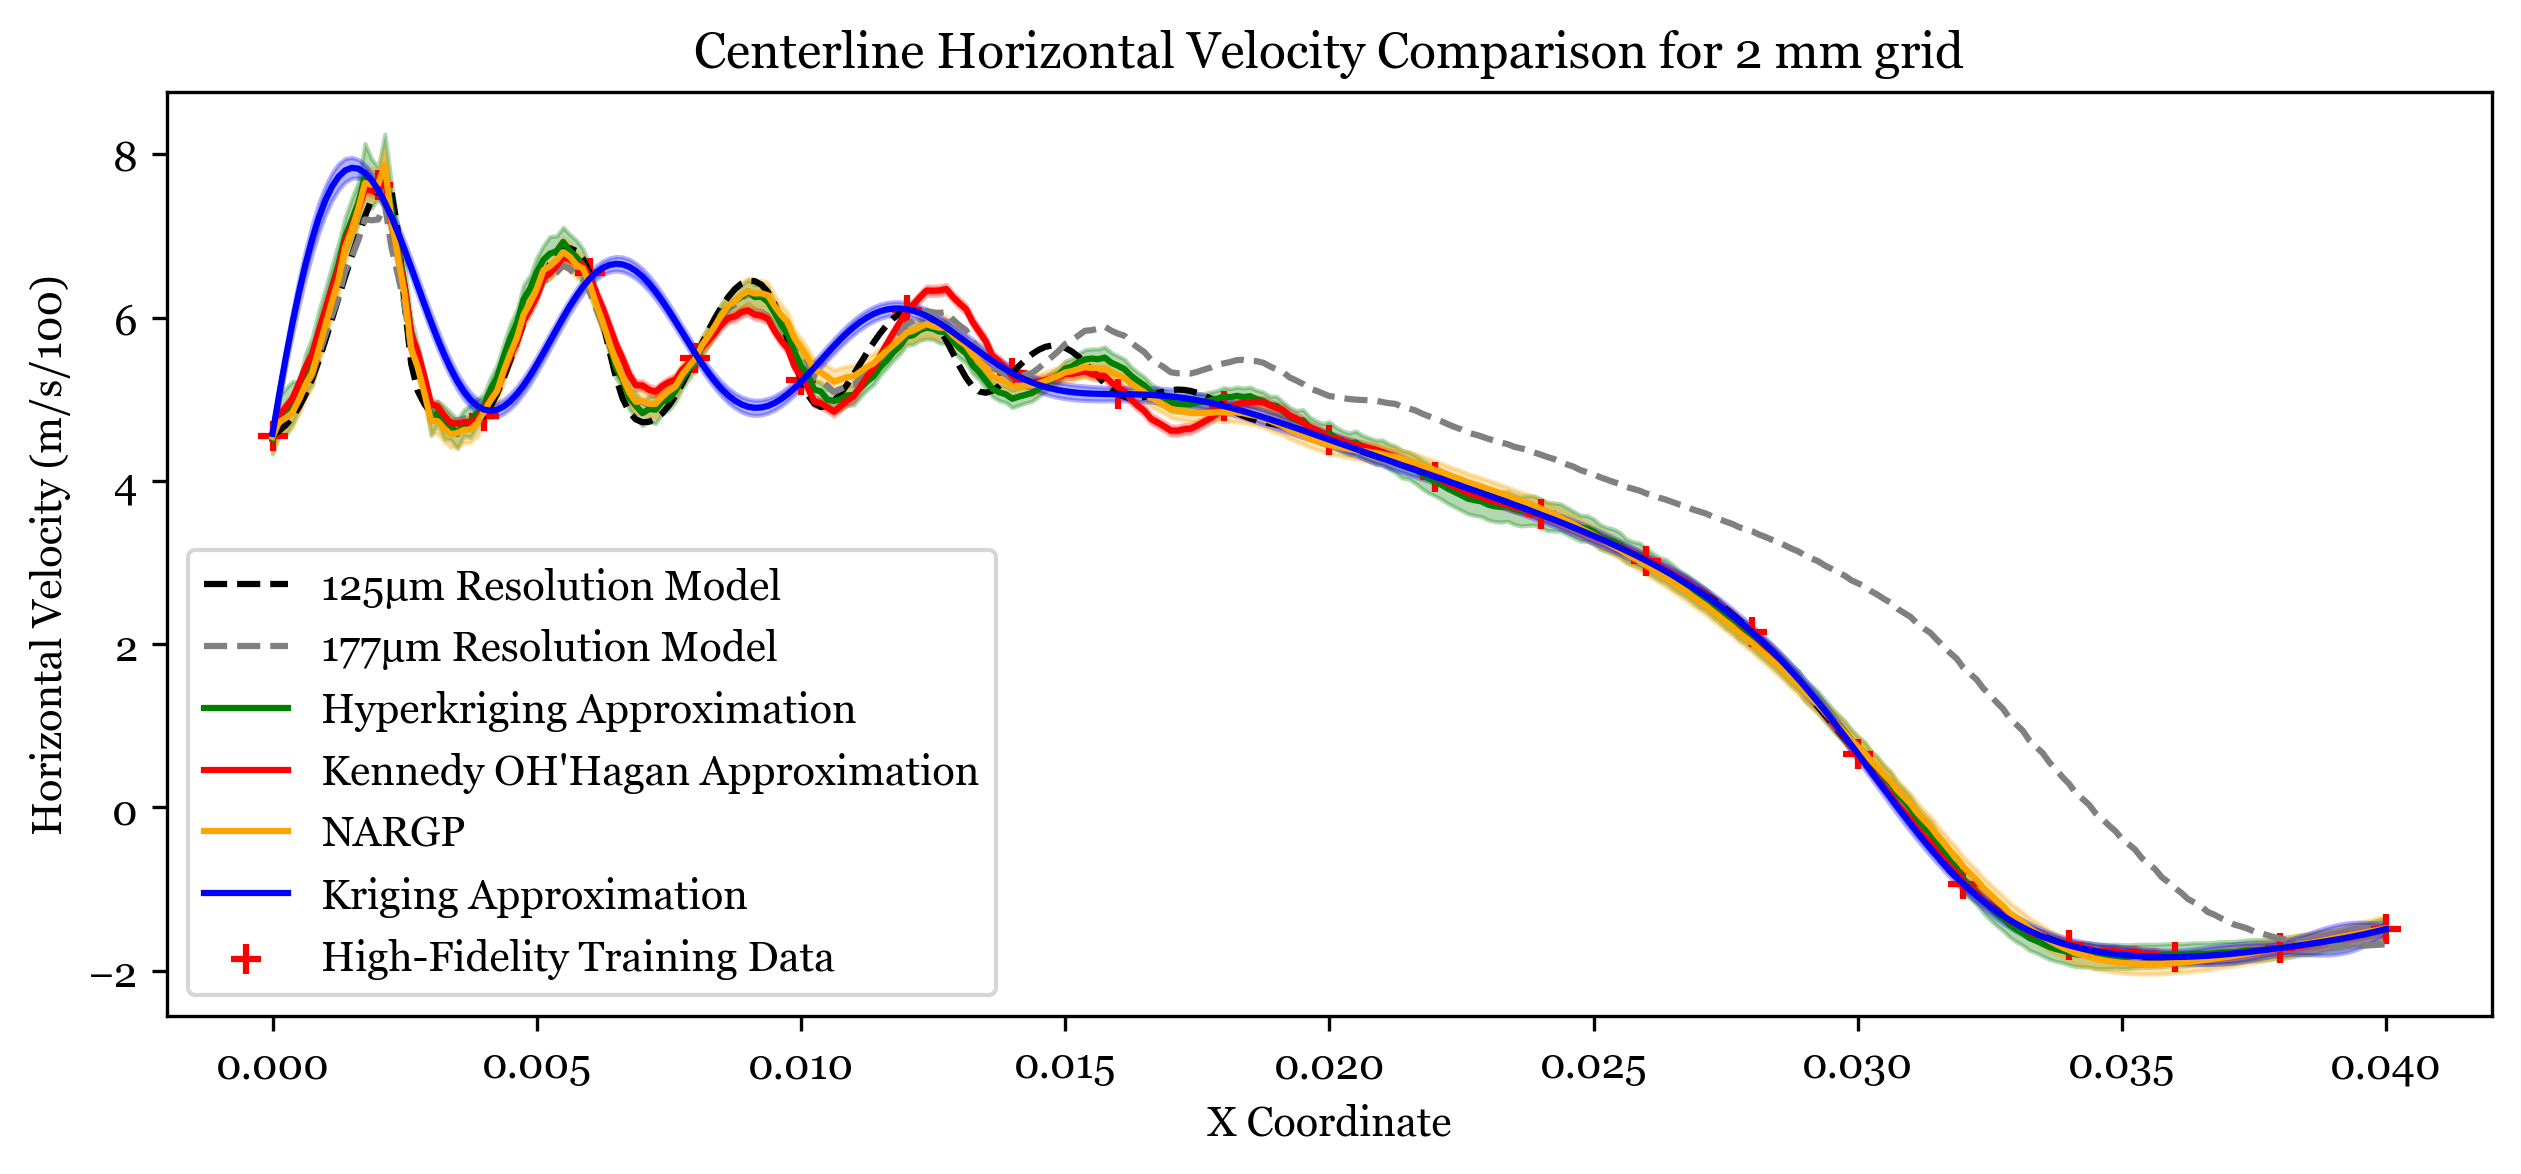

In [29]:
jet_criterion = (Xtest[:,1] == Xtest[:,1].min()) & (scaler.inverse_transform(Xtest)[:,0] <= (x_partitions-1) * grid_spacing)
Xjet, Yjet, Fjet = Xtest[jet_criterion,:], Ytest[jet_criterion], test_features[jet_criterion, :]

hk_jet, cov_jet = hk_model.predict(Fjet)
conf = 2*np.sqrt(np.diag(cov_jet))

delta_mean, delta_cov = delta.predict(Xjet, full_cov = False)
koh_jet, koh_cov_jet = delta.p['rho'] * Fjet[:,-1] + delta_mean, delta_cov
koh_conf = 2*np.sqrt(koh_cov_jet)

kr_jet, kr_cov = kr_model.predict(Xjet)
kr_conf = 2 * np.sqrt(np.diag(kr_cov))

nargp_jet, cov_jet = nargp.predict(jnp.hstack((Xjet, Fjet[:,-1].reshape(-1,1))))
nargp_conf = 2*np.sqrt(np.diag(cov_jet))

plt.figure(figsize=(10,4), dpi = 300)
plt.plot(scaler.inverse_transform(Xjet)[:,0], Yjet, label = "125μm Resolution Model", color = 'black', linestyle = 'dashed')
plt.plot(scaler.inverse_transform(Xjet)[:,0], test_features[jet_criterion,5], label = "177μm Resolution Model", color = 'gray', linestyle = 'dashed')
plt.plot(scaler.inverse_transform(Xjet)[:,0], hk_jet, label = "Hyperkriging Approximation", color = 'green')
plt.fill_between(scaler.inverse_transform(Xjet)[:,0], hk_jet - conf, hk_jet + conf, color = 'green', alpha = 0.3)
plt.plot(scaler.inverse_transform(Xjet)[:,0], koh_jet, label = "Kennedy OH'Hagan Approximation", color = 'red')
plt.fill_between(scaler.inverse_transform(Xjet)[:,0], koh_jet - koh_conf, koh_jet + koh_conf, color = 'red', alpha = 0.3, label = None)
plt.plot(scaler.inverse_transform(Xjet)[:,0], nargp_jet, label = "NARGP", color = 'orange')
plt.fill_between(scaler.inverse_transform(Xjet)[:,0], nargp_jet - nargp_conf, nargp_jet + nargp_conf, color = 'orange', alpha = 0.3, label = None)

plt.plot(scaler.inverse_transform(Xjet)[:,0], kr_jet, label = "Kriging Approximation", color = 'blue')
plt.fill_between(scaler.inverse_transform(Xjet)[:,0], kr_jet - kr_conf, kr_jet + kr_conf, color = 'blue', alpha = 0.3)
plt.scatter(scaler.inverse_transform(Xtrain)[Xtrain[:,1] == Xtrain[:,1].min(), 0], Ytrain[Xtrain[:,1] == Xtrain[:,1].min()], marker = '+', color = 'red', label = 'High-Fidelity Training Data', s = 50.0)
plt.xlabel("X Coordinate")
plt.ylabel("Horizontal Velocity (m/s/100)")
plt.title("Centerline Horizontal Velocity Comparison for %d mm grid" % (grid_spacing * 1000))
plt.legend()

In [30]:
print("Method           Jet RMSE       Grid RMSE          R^2          Log MLL")
print("---------------------------------------------------------------------------")
print("Hyperkriging:    %.4e  &   %.4e  &  %.4f  &  %.4e \\\\" % (jnp.sqrt(MSE(Ytest[jet_criterion], hk_mean[jet_criterion])), jnp.sqrt(MSE(Ytest[grid_criterion], hk_mean[grid_criterion])), np.corrcoef(Ytest[grid_criterion], hk_mean[grid_criterion])[0,1], neg_mll(hk_model, hk_model.p)))
print("Kennedy OH:      %.4e  &   %.4e  &  %.4f  &  %.4e \\\\" % (jnp.sqrt(MSE(Ytest[jet_criterion], koh_mean[jet_criterion])), jnp.sqrt(MSE(Ytest[grid_criterion], koh_mean[grid_criterion])), np.corrcoef(Ytest[grid_criterion], koh_mean[grid_criterion])[0,1], delta_neg_mll(delta, delta.p)))
print("NARGP:           %.4e  &   %.4e  &  %.4f  &  %.4e \\\\" % (jnp.sqrt(MSE(Ytest[jet_criterion], nargp_mean[jet_criterion])), jnp.sqrt(MSE(Ytest[grid_criterion], nargp_mean[grid_criterion])), np.corrcoef(Ytest[grid_criterion], nargp_mean[grid_criterion])[0,1], neg_mll(nargp, nargp.p)))
print("Kriging:         %.4e  &   %.4e  &  %.4f  &  %.4e \\\\" % (jnp.sqrt(MSE(Ytest[jet_criterion], kr_mean[jet_criterion])), jnp.sqrt(MSE(Ytest[grid_criterion], kr_mean[grid_criterion])), np.corrcoef(Ytest[grid_criterion], kr_mean[grid_criterion])[0,1], neg_mll(kr_model, kr_model.p)))
print("177:             %.4e  &   %.4e  &  %.4f  &  N/A \\\\" % (jnp.sqrt(MSE(Ytest[jet_criterion], test_features[jet_criterion, 5])), jnp.sqrt(MSE(Ytest[grid_criterion], test_features[grid_criterion, 5])), np.corrcoef(Ytest[grid_criterion], test_features[grid_criterion, 5])[0,1]))
print("250:             %.4e  &   %.4e  &  %.4f  &  N/A \\\\" % (jnp.sqrt(MSE(Ytest[jet_criterion], test_features[jet_criterion, 4])), jnp.sqrt(MSE(Ytest[grid_criterion], test_features[grid_criterion, 4])), np.corrcoef(Ytest[grid_criterion], test_features[grid_criterion, 4])[0,1]))
print("500:             %.4e  &   %.4e  &  %.4f  &  N/A \\\\" % (jnp.sqrt(MSE(Ytest[jet_criterion], test_features[jet_criterion, 3])), jnp.sqrt(MSE(Ytest[grid_criterion], test_features[grid_criterion, 3])), np.corrcoef(Ytest[grid_criterion], test_features[grid_criterion, 3])[0,1]))
print("RANS:            %.4e  &   %.4e  &  %.4f  &  N/A \\\\" % (jnp.sqrt(MSE(Ytest[jet_criterion], test_features[jet_criterion, 2])), jnp.sqrt(MSE(Ytest[grid_criterion], test_features[grid_criterion, 2])), np.corrcoef(Ytest[grid_criterion], test_features[grid_criterion, 2])[0,1]))

Method           Jet RMSE       Grid RMSE          R^2          Log MLL
---------------------------------------------------------------------------
Hyperkriging:    1.6496e-01  &   8.1847e-02  &  0.9997  &  -1.7890e+02 \\
Kennedy OH:      2.0636e-01  &   1.2735e-01  &  0.9992  &  -9.1522e+01 \\
NARGP:           1.5590e-01  &   8.3659e-02  &  0.9997  &  -1.3882e+02 \\
Kriging:         5.3833e-01  &   3.4416e-01  &  0.9945  &  2.7387e+02 \\
177:             1.0143e+00  &   4.1232e-01  &  0.9921  &  N/A \\
250:             2.1094e+00  &   7.8781e-01  &  0.9705  &  N/A \\
500:             2.0721e+00  &   1.1332e+00  &  0.9392  &  N/A \\
RANS:            1.5772e+00  &   6.7716e-01  &  0.9782  &  N/A \\
